In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# I have experienced stability issues with float32.
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import HH
from jaxley.synapses import GlutamateSynapse

### Setup

In [5]:
# Number of segments per branch.
nseg_per_branch = 8

# Stimulus.
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

In [6]:
time_vec = jnp.arange(0.0, t_max+dt, dt)

### Define compartment and branch

In [7]:
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=nseg_per_branch)

### Define cell

Below, we define the morphology. Each element of `parents` corresponds to one branch. A `-1` entry means that this branch does not have a parent. Alternatively, you could also load cells from SWC with 

```cell = jx.read_swc(fname, nseg=4)```.

In [8]:
num_branches = 15
parents = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])
assert len(parents) == num_branches

In [9]:
cell = jx.Cell(branch, parents=parents)

Cells can be visualized as follows:

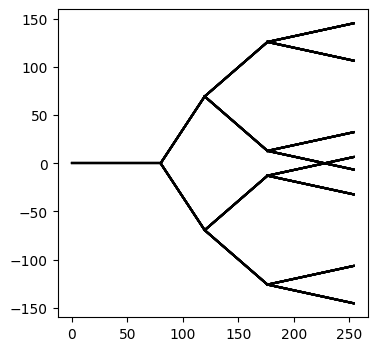

In [10]:
cell.compute_xyz()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
_ = cell.vis(ax=ax)

### Define connectivity

In this case, two layers fully connected.

In [11]:
num_cells = 16

In [12]:
network = jx.Network([cell for _ in range(num_cells)])

In [13]:
# Layer 1
pre = network.cell([0, 1, 2, 3, 4])
post = network.cell(np.arange(5, 15).tolist())
pre.fully_connect(post, GlutamateSynapse())

# Layer 2
pre = network.cell(np.arange(5, 15).tolist())
post = network.cell(15)
pre.fully_connect(post, GlutamateSynapse())

Networks can be visualized as point neurons:

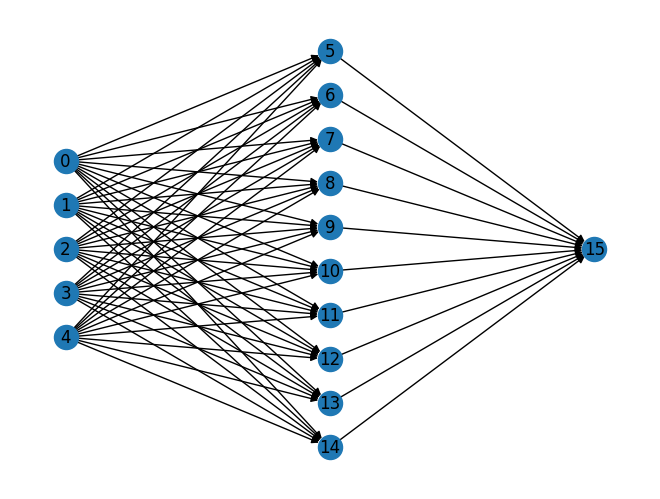

In [14]:
network.vis(detail="point", layers=[5, 10, 1])

But they can also be visualized with full morphological detail. In that case, you have to manually move neurons where you want them to be:

In [15]:
for i in range(5):
    network.cell(i).move(x=0, y=200 * i)

for i in range(5, 15):
    network.cell(i).move(x=400, y=200 * i - 1500)

for i in range(15, 16):
    network.cell(i).move(x=800, y=500)

<Axes: >

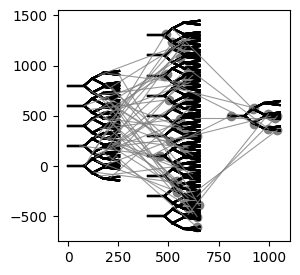

In [16]:
network.vis(detail="full", synapse_col="gray", synapse_plot_kwargs={"alpha": 0.8, "linewidth": 0.8})

### Insert mechanisms

In [18]:
network.insert(HH())

### Define stimuli and recordings

In [19]:
for cell_ind in range(num_cells):
    network.cell(cell_ind).branch(0).comp(0.0).record()

current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
for stim_ind in range(5):
    network.cell(stim_ind).branch(0).comp(0.0).stimulate(current)

### Solve ODE

In [20]:
%%time
s = jx.integrate(network, delta_t=dt)

CPU times: user 1.71 s, sys: 25.6 ms, total: 1.73 s
Wall time: 1.75 s


### jit compilation

We can jit-compile the simulation in order to make it faster. The code below will be slow when run for the first time, but fast upon the second run.

In [21]:
def run_sim():
    return jx.integrate(network, delta_t=dt)

jitted_run_sim = jit(run_sim)

In [22]:
%%time
s = jitted_run_sim()

CPU times: user 1.35 s, sys: 21.8 ms, total: 1.37 s
Wall time: 1.37 s


### Visualize traces

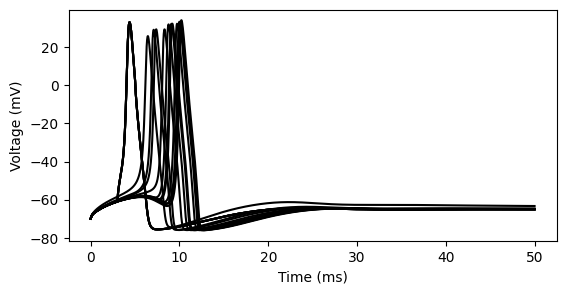

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6.3, 3))
for i in range(num_cells):
    _ = ax.plot(time_vec, s[i][:-1], c="k")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (mV)")
plt.show()